In [ ]:
 import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
#from Preprocessing import clean_text, remove_names, entity_recognizing, remove_url
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import l2
from keras.layers import Bidirectional
import re
import os
import keras
from keras.utils.vis_utils import plot_model

%matplotlib inline
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
path = "/content/drive/MyDrive/IAS/NLP_and_Web/data/fox_news.csv"
df_training = pd.read_csv(path)
df_training = df_training.rename(columns={'class': 'label'})
df_training.head()

,Unnamed: 0,comment,label
0,0,Merkel would never say NO,2
1,1,"Expect more and more women to be asking .. ""wh...",2
2,2,Groping people in public wasn't already illega...,0
3,3,"Merkel, possible the only person in charge who...",2
4,4,"They know very well, no means NO They need to ...",2


In [ ]:
df_training['label'].value_counts()


0    1083
2     430
Name: label, dtype: int64

In [ ]:
df_training.duplicated(subset=['comment']).value_counts()

False    1513
dtype: int64

In [ ]:
#converting hate label(2) to hate label(1)
df_training.replace({2:1}, inplace=True)
df_training

,Unnamed: 0,comment,label
0,0,Merkel would never say NO,1
1,1,"Expect more and more women to be asking .. ""wh...",1
2,1,Groping people in public wasn't already illega...,0
3,3,"Merkel, possible the only person in charge who...",1
4,4,"They know very well, no means NO They need to ...",1
...,...,...,...
1508,1523,"No, 10000 Loose nuts off their meds",1
1509,1524,Just another ugly leftist.,1
1510,1525,"True. Most leftists ,esp female leftists have ...",1
1511,1526,"First, lets get this straight",1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c679e24d0>],
      dtype=object)

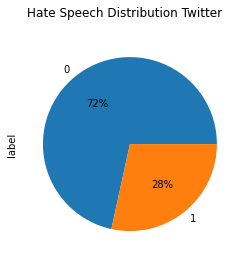

In [ ]:
df_training.label.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Hate Speech Distribution Twitter')


## class = class label for Fox news. 1 - hate speech 0 - non hate

In [ ]:
def filter_hatespeech_texts(df):
    
    def filter_texts(text):
        return re.sub('@.\:|!|@\w+:|@[\w]*|&#[0-9]*;|#\w+|RT|\/\/t.co\/\w+|&gt|&lt', '', text)

    def postprocess_filter_texts(text):
        
        return df

    df['comment'] = df['comment'].apply(filter_texts)
    df.replace("", np.nan, inplace=True)
    df = df.dropna()
    
    
    return df

df_training = filter_hatespeech_texts(df_training)

In [ ]:
TEXT_COLUMN = "comment"
LABEL_COLUMN = "label"

print("Converting to lower-case")
df_training[TEXT_COLUMN] = df_training[TEXT_COLUMN].str.lower()
print(df_training.head())

Converting to lower-case
   Unnamed: 0                                            comment  label
0           0                          merkel would never say no      1
1           1  expect more and more women to be asking .. "wh...      1
2           1  groping people in public wasn't already illega...      0
3           3  merkel, possible the only person in charge who...      1
4           4  they know very well, no means no they need to ...      1


In [ ]:
df_training['doc_len'] = df_training[TEXT_COLUMN].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df_training['doc_len'].mean() + df_training['doc_len'].std()).astype(int)

In [ ]:
df_training.head()

,Unnamed: 0,comment,label,doc_len
0,0,merkel would never say no,1,5
1,1,"expect more and more women to be asking .. ""wh...",1,28
2,1,groping people in public wasn't already illega...,0,12
3,3,"merkel, possible the only person in charge who...",1,80
4,4,"they know very well, no means no they need to ...",1,20


## Splitting the data

In [ ]:
seed = 11
test_size = 0.2
# categories = ['not hate speech', 'hate speech]
categories = [0,1]
def split_dataset(df, seed, test_size):
    train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    #val, test = train_test_split(test, test_size=0.5, random_state=seed, shuffle=True)
    return train.comment, train.label, test.comment, test.label  #, val.comment, val.label
    #return df.comment, df.label, df.comment, df.label

In [ ]:
train, train_targets, test, test_targets = split_dataset(df_training, seed=seed, test_size=test_size)

In [ ]:
type(train_targets.values)

numpy.ndarray

In [ ]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1]]

In [ ]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)

In [ ]:
embed_size = 300  # how big is each word vector
max_features = None  # how many unique words to use (i.e num rows in embedding vector)
maxlen = max_seq_len  # max number of words in a question to use #99.99%

def encode(data, label):
    # fill up the missing values
    X = data.fillna("_na_").values
    total_texts = df_training.comment.fillna("_na_").values
    
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(list(total_texts))
    X = tokenizer.texts_to_sequences(X)
    vocab_size = len(tokenizer.word_index) + 1
    print(tokenizer.word_index)
    
    # Pad the sentences
    X = pad_sequences(X, maxlen=maxlen)
    print(X.shape)
    
    # Get the target values
    y = pd.get_dummies(label.values)
    print(y.shape)
    #le = LabelEncoder()
    #le.fit(Y_train)
    #encoded_Y = le.transform(Y_train)
    return X,y,vocab_size
    

In [ ]:
max_seq_len

56

In [ ]:
type(train)

pandas.core.series.Series

In [ ]:
# FETCH DATA, LABELS, DICTIONARIES
X_train, y_train, vocab_size = encode(train, train_targets)
X_test, y_test, vocab_size = encode(test, test_targets)

print(vocab_size)

{'the': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'is': 6, 'in': 7, 'that': 8, 'you': 9, 'i': 10, 'are': 11, 'for': 12, 'it': 13, 'they': 14, 'not': 15, 'have': 16, 'be': 17, 'with': 18, 'on': 19, 'this': 20, 'as': 21, 'was': 22, 'people': 23, 'who': 24, 'all': 25, 'your': 26, 'will': 27, 'what': 28, 'but': 29, 'or': 30, 'their': 31, 'if': 32, 'no': 33, 'just': 34, 'so': 35, 'we': 36, 'do': 37, 'by': 38, 'like': 39, 'an': 40, 'has': 41, 'from': 42, 'at': 43, 'would': 44, 'can': 45, 'get': 46, 'about': 47, 'he': 48, 'she': 49, 'should': 50, "don't": 51, 'them': 52, 'how': 53, 'there': 54, 'more': 55, 'because': 56, "it's": 57, 'up': 58, 'one': 59, 'my': 60, 'than': 61, 'out': 62, 'only': 63, 'when': 64, 'his': 65, 'why': 66, 'any': 67, 'our': 68, 'white': 69, 'make': 70, 'some': 71, 'obama': 72, 'then': 73, 'these': 74, 'her': 75, 'been': 76, 'want': 77, 'were': 78, 'think': 79, 'did': 80, 'never': 81, 'does': 82, 'work': 83, 'after': 84, 'flag': 85, 'country': 86, 'know': 87, 'many': 88, 

In [ ]:
y_train

,0,1
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
1205,1,0
1206,0,1
1207,1,0
1208,0,1


In [ ]:
epochs = 8
batch_size = 16
lr = 0.001



# model = Sequential()
# model.add(Embedding(vocab_size, embed_size, input_length=X_train.shape[1]))
# model.add(Bidirectional(LSTM(64,go_backwards= True, kernel_regularizer=l2(0.05), 
#                              recurrent_regularizer=l2(0.05), bias_regularizer=l2(0.05))))
# model.add(Dense(2, activation='softmax'))

model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(64,go_backwards= True, return_sequences= True)))
model.add(Bidirectional(LSTM(64,go_backwards= True)))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 56, 300)           2344200   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 56, 128)           186880    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 2,630,154
Trainable params: 2,630,154
Non-trainable params: 0
_________________________________________________________________


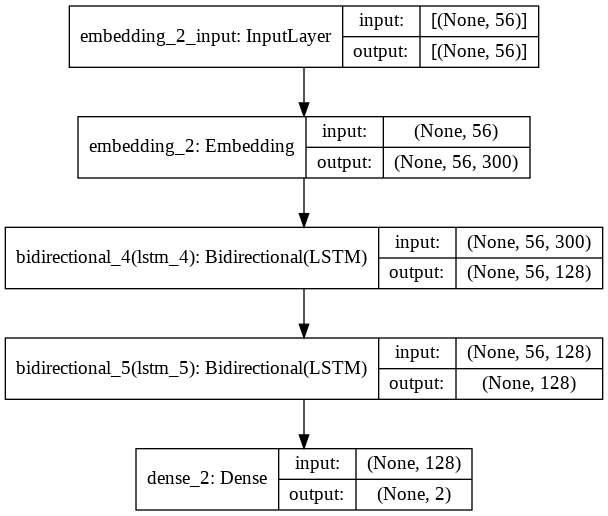

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, 
      epochs=epochs,  
      verbose=1, 
      batch_size=batch_size)

Epoch 1/8
76/76 [==============================] - 20s 150ms/step - loss: 0.6197 - accuracy: 0.7001 - precision_2: 0.7078 - recall_2: 0.7078
Epoch 2/8
76/76 [==============================] - 11s 148ms/step - loss: 0.3943 - accuracy: 0.8146 - precision_2: 0.7240 - recall_2: 0.7240
Epoch 3/8
76/76 [==============================] - 11s 148ms/step - loss: 0.0409 - accuracy: 0.9924 - precision_2: 0.8048 - recall_2: 0.8048
Epoch 4/8
76/76 [==============================] - 11s 148ms/step - loss: 0.0152 - accuracy: 0.9963 - precision_2: 0.8618 - recall_2: 0.8618
Epoch 5/8
76/76 [==============================] - 11s 148ms/step - loss: 5.9494e-04 - accuracy: 1.0000 - precision_2: 0.8943 - recall_2: 0.8943
Epoch 6/8
76/76 [==============================] - 11s 147ms/step - loss: 3.3217e-04 - accuracy: 1.0000 - precision_2: 0.9144 - recall_2: 0.9144
Epoch 7/8
76/76 [==============================] - 11s 148ms/step - loss: 1.8478e-04 - accuracy: 1.0000 - precision_2: 0.9281 - recall_2: 0.9281
E

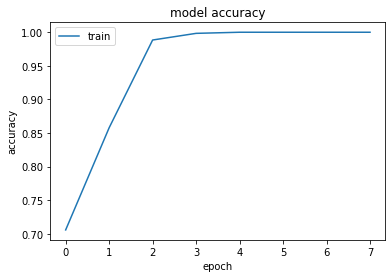

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

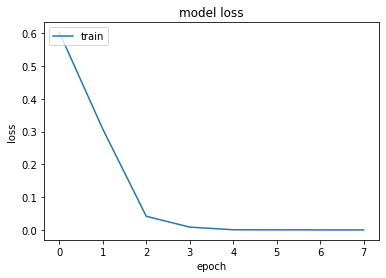

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate the model to get metrics for Test data

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test,batch_size=32)
print("loss: %s accuracy: %s precision: %s recall: %s" % (loss, accuracy, precision, recall))
df_evaluation = pd.DataFrame({'loss':loss, 'accuracy':accuracy, 'precision': precision, 'recall':recall},index=[0])

name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/evaluation_logs_Bi-LSTM_fox.csv'
df_evaluation.to_csv(name)

10/10 [==============================] - 3s 36ms/step - loss: 1.7794 - accuracy: 0.6799 - precision_2: 0.9389 - recall_2: 0.9389
loss: 1.7794257402420044 accuracy: 0.6798679828643799 precision: 0.9388598203659058 recall: 0.9388598203659058


In [ ]:
model.save('/content/drive/MyDrive/IAS/NLP_and_Web/Model/training_model_Bi-LSTM_Fox.h5')

### Perform predictions on the Test data

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/IAS/NLP_and_Web/Model/training_model_Bi-LSTM_Fox.h5')
Y_pred = model.predict(X_test)
print(Y_pred.shape)
print(Y_pred)
Y_pred = np.argmax(Y_pred, axis=1)
print(Y_pred)

(303, 2)
[[1.76229529e-04 9.99823749e-01]
 [9.99075413e-01 9.24562162e-04]
 [9.98882592e-01 1.11739826e-03]
 [9.99953628e-01 4.63422912e-05]
 [9.99900460e-01 9.94987276e-05]
 [3.69097805e-03 9.96308982e-01]
 [9.99284327e-01 7.15679373e-04]
 [8.84478271e-01 1.15521699e-01]
 [9.99955893e-01 4.41009979e-05]
 [9.99871373e-01 1.28577638e-04]
 [6.52046641e-03 9.93479490e-01]
 [9.99909759e-01 9.02612810e-05]
 [9.95957434e-01 4.04257560e-03]
 [9.99219298e-01 7.80637492e-04]
 [9.99543190e-01 4.56846261e-04]
 [3.30500101e-04 9.99669552e-01]
 [9.98905420e-01 1.09455537e-03]
 [9.98743832e-01 1.25617406e-03]
 [9.99945045e-01 5.49292236e-05]
 [9.96514797e-01 3.48520908e-03]
 [1.00347900e-03 9.98996556e-01]
 [9.39570844e-01 6.04291148e-02]
 [9.97474968e-01 2.52503669e-03]
 [9.99904633e-01 9.53271519e-05]
 [9.99727547e-01 2.72401201e-04]
 [9.99837756e-01 1.62226846e-04]
 [9.99885321e-01 1.14704882e-04]
 [9.98512089e-01 1.48793391e-03]
 [9.99885440e-01 1.14601782e-04]
 [8.27122058e-05 9.99917269e-01]
 

### Generate Classifiction report for predictions on Fox data

In [ ]:
categories = ['not hate speech', 'hate speech']
 
report = classification_report(test_targets.values, Y_pred, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
not hate speech,0.833333,0.720524,0.772834,229.000000
hate speech,0.390476,0.554054,0.458101,74.000000
accuracy,0.679868,0.679868,0.679868,0.679868
macro avg,0.611905,0.637289,0.615467,303.000000
weighted avg,0.725177,0.679868,0.695968,303.000000


In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/matrix_report_Bi-LSTM_FoxNews.csv'
df_report.to_csv(name)

In [ ]:
df_results = pd.DataFrame(history.history)
df_results['learning_rate'] = lr
df_results['num_epochs'] = epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] =  len(categories) 
df_results['test_size'] = test_size
df_results['train_size'] = len(train)
df_results['seed'] = seed
df_results['Tokenizer'] = 'keras_preprocessing.text.Tokenizer'
df_results['loss_function'] = 'categorical_crossentropy'
df_results['learning_rate'] = lr
df_results['train_class_proportion_' + categories[0]] = round(train_class_distribution[0][1], 2)
df_results['train_class_proportion_' + categories[1]] = round(train_class_distribution[1][1], 2)
df_results['test_class_proportion_' + categories[0]] = round(test_class_distribution[0][1], 2)
df_results['test_class_proportion_' + categories[1]] = round(test_class_distribution[1][1], 2)


In [ ]:
df_results.head()

,loss,accuracy,precision_2,recall_2,learning_rate,num_epochs,batch_size,num_classes,test_size,train_size,seed,Tokenizer,loss_function,train_class_proportion_not hate speech,train_class_proportion_hate speech,test_class_proportion_not hate speech,test_class_proportion_hate speech
0,0.602856,0.705785,0.699975,0.699975,0.001,8,16,2,0.2,1210,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24
1,0.307617,0.857851,0.745327,0.745327,0.001,8,16,2,0.2,1210,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24
2,0.041733,0.988430,0.821918,0.821918,0.001,8,16,2,0.2,1210,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24
3,0.008668,0.998347,0.871048,0.871048,0.001,8,16,2,0.2,1210,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24
4,0.000631,1.000000,0.899876,0.899876,0.001,8,16,2,0.2,1210,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24


In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/training_logs_Bi-LSTM_FoxNews.csv'
df_results.to_csv(name)

In [ ]:
def plot_loss(path, ax, title):
    df = pd.read_csv(path)
    df.loss.plot(kind='line', legend=True, title=title, ax=ax, figsize=(15,8))
    ax.legend(loc='upper right')
    plt.xlabel('Step') 
    plt.ylabel('Loss')

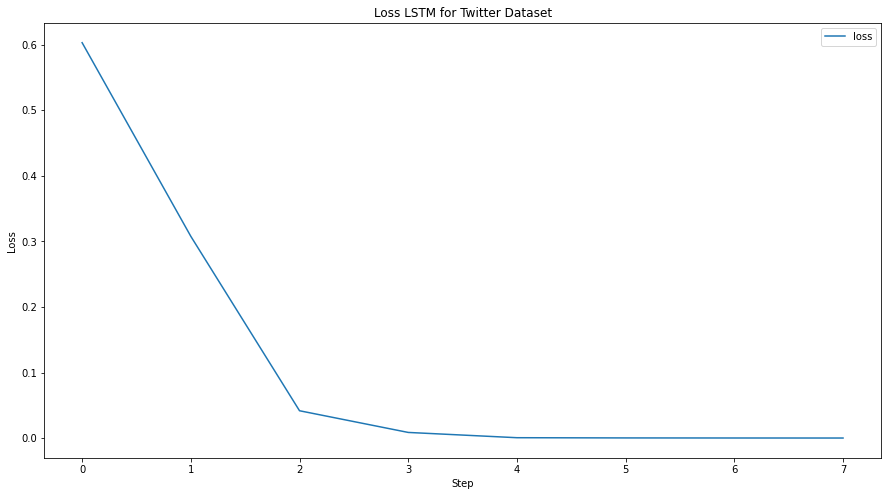

In [ ]:
fig, axs = plt.subplots(1,1)
path = '/content/drive/MyDrive/IAS/NLP_and_Web/report/training_logs_Bi-LSTM_FoxNews.csv'
plot_loss(path, axs, title='Loss LSTM for Twitter Dataset')

### Test the model on the 6 movies Dataset

Loading the Movies dataset and preparing the encodings for each utterences

In [ ]:
df_AllMovie = pd.read_csv('/content/drive/MyDrive/IAS/NLP_and_Web/data/all_movies.csv')
df_AllMovie

,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX
...,...,...,...,...,...,...
10683,10683,TheWolfofWallStreet2013BluRay_3724,3859903933,0,Sell me this pen.,TheWolfofWallStreet
10684,10684,TheWolfofWallStreet2013BluRay_3725,3859903933,0,"Well, it's a nice pen.",TheWolfofWallStreet
10685,10685,TheWolfofWallStreet2013BluRay_3726_3727,3859903933,0,You can use the pen to write down thoughts fro...,TheWolfofWallStreet
10686,10686,TheWolfofWallStreet2013BluRay_3728,3859903933,0,Sell me this pen.,TheWolfofWallStreet


####combining (Hate + offensive) labels in all movies dataset together as Hate

In [ ]:
 #make the all movies dataset as 0: neither, 1:hate (the hate and offensive labels are clubbed together into hate(1))
df_AllMovie["majority_answer"].replace({2:1}, inplace=True)
df_AllMovie

,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX
...,...,...,...,...,...,...
10683,10683,TheWolfofWallStreet2013BluRay_3724,3859903933,0,Sell me this pen.,TheWolfofWallStreet
10684,10684,TheWolfofWallStreet2013BluRay_3725,3859903933,0,"Well, it's a nice pen.",TheWolfofWallStreet
10685,10685,TheWolfofWallStreet2013BluRay_3726_3727,3859903933,0,You can use the pen to write down thoughts fro...,TheWolfofWallStreet
10686,10686,TheWolfofWallStreet2013BluRay_3728,3859903933,0,Sell me this pen.,TheWolfofWallStreet


In [ ]:
X_test_AllMovie, y_test_AllMovie, vocab_size = encode(df_AllMovie['text'], df_AllMovie['majority_answer'])
print(vocab_size)

{'the': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'is': 6, 'in': 7, 'that': 8, 'you': 9, 'i': 10, 'are': 11, 'for': 12, 'it': 13, 'they': 14, 'not': 15, 'have': 16, 'be': 17, 'with': 18, 'on': 19, 'this': 20, 'as': 21, 'was': 22, 'people': 23, 'who': 24, 'all': 25, 'your': 26, 'will': 27, 'what': 28, 'but': 29, 'or': 30, 'their': 31, 'if': 32, 'no': 33, 'just': 34, 'so': 35, 'we': 36, 'do': 37, 'by': 38, 'like': 39, 'an': 40, 'has': 41, 'from': 42, 'at': 43, 'would': 44, 'can': 45, 'get': 46, 'about': 47, 'he': 48, 'she': 49, 'should': 50, "don't": 51, 'them': 52, 'how': 53, 'there': 54, 'more': 55, 'because': 56, "it's": 57, 'up': 58, 'one': 59, 'my': 60, 'than': 61, 'out': 62, 'only': 63, 'when': 64, 'his': 65, 'why': 66, 'any': 67, 'our': 68, 'white': 69, 'make': 70, 'some': 71, 'obama': 72, 'then': 73, 'these': 74, 'her': 75, 'been': 76, 'want': 77, 'were': 78, 'think': 79, 'did': 80, 'never': 81, 'does': 82, 'work': 83, 'after': 84, 'flag': 85, 'country': 86, 'know': 87, 'many': 88, 

0    9014
1    1674
Name: majority_answer, dtype: int64


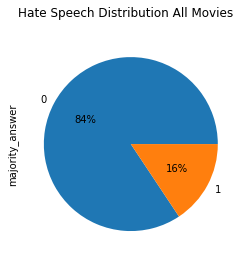

In [ ]:
df_AllMovie.majority_answer.value_counts().plot(kind='pie', subplots=True,autopct='%1.0f%%', title='Hate Speech Distribution All Movies')
print(df_AllMovie.majority_answer.value_counts())

In [ ]:
def annotate_all_movie(movie_df, X_test):
    utterances = X_test
    predictions = []
    batch = []
    

    predictions = model.predict(utterances)
    print(predictions)
    predictions = np.argmax(predictions, axis=1)
    print(predictions[0:10])


    result = []
    
    for i, pred in enumerate(predictions):
        result.append({'index': i, 'label_LSTM_FoxNews': pred})
    
    result_df = pd.DataFrame(result)
    movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
    # del movie_df['Unnamed: 0']
    # del movie_df['Unnamed: 6']
    # del movie_df['Unnamed: 7']
    del movie_df['index']

    return movie_df

In [ ]:
annotated_all_movie =  annotate_all_movie(df_AllMovie, X_test_AllMovie) 
annotated_all_movie.head(10)

[[9.5356774e-01 4.6432212e-02]
 [9.9952543e-01 4.7460585e-04]
 [8.1106871e-03 9.9188930e-01]
 ...
 [9.9936336e-01 6.3660333e-04]
 [9.9969375e-01 3.0626354e-04]
 [9.9964476e-01 3.5529450e-04]]
[0 0 1 0 0 0 0 0 0 1]


,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name,label_LSTM_FoxNews
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX,0
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX,0
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX,1
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX,0
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX,0
5,5,AmericanHistoryX(1998)_6,1566624979,0,What's going on?,AmerricanHistoryX,0
6,6,AmericanHistoryX(1998)_7,1566624979,0,"Not right now, honey. How many?",AmerricanHistoryX,0
7,7,AmericanHistoryX(1998)_8,1566624979,0,"Danny, how many?",AmerricanHistoryX,0
8,8,AmericanHistoryX(1998)_9,1566624979,0,"One, I think.",AmerricanHistoryX,0
9,9,AmericanHistoryX(1998)_10,1566624979,0,Is he strapped?,AmerricanHistoryX,1


In [ ]:
annotated_all_movie.to_csv('/content/drive/MyDrive/IAS/NLP_and_Web/annotations/annotations_train_FoxNews_BI-LSTM_test_movies.csv')

In [ ]:
annotated_all_movie[(annotated_all_movie['majority_answer']==1)]['label_LSTM_FoxNews'].value_counts()

0    1336
1     338
Name: label_LSTM_FoxNews, dtype: int64

In [ ]:
categories = ['not hate speech', 'hate speech']
 
report = classification_report(annotated_all_movie['majority_answer'].values, annotated_all_movie['label_LSTM_FoxNews'].values, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
not hate speech,0.845710,0.812403,0.828722,9014.000000
hate speech,0.166585,0.201912,0.182555,1674.000000
accuracy,0.716785,0.716785,0.716785,0.716785
macro avg,0.506147,0.507157,0.505638,10688.000000
weighted avg,0.739342,0.716785,0.727516,10688.000000


In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/matrix_report_train_FoxNews_BI-LSTM_test_movies.csv'
df_report.to_csv(name)

## Classication of Movies

### Load Movies

In [ ]:
# def read_movie_files(pathes):
#     result = []
#     for path in pathes: 
#         directory = os.fsencode(path)

#         for file in os.listdir(directory):
#             filename = os.fsdecode(file)

#             if filename.endswith(".csv"):
#                 #print(os.path.join(directory, filename))
#                 #local_df = read_content(path + '//' + filename)
#                 movie_df = pd.read_csv(path + '//' + filename)
#                 tag = path.split('/')[-1]
#                 count_utterances = movie_df.shape[0]
#                 result.append({'movie_name': filename[:-9], 'count_utterances': count_utterances, 'tag': tag, 'path': path + '//' + filename})
#     result_df = pd.DataFrame(result)
#     return result_df

In [ ]:
# pathes = ['drive/MyDrive/IAS/Semester3/NLP/movies/racism', 'drive/MyDrive/IAS/Semester3/NLP/movies/hate_speech', 'drive/MyDrive/IAS/Semester3/NLP/movies/friendship']

In [ ]:
# movie_metadata_df = read_movie_files(pathes)
# movie_metadata_df.head()

In [ ]:
# movie_metadata_df.tag.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Movie Tag Distribution')

In [ ]:
# path = 'drive/MyDrive/IAS/Semester3/NLP/data/all_movies.csv'
# all_movie_data = pd.read_csv(path, index_col=0)

In [ ]:
# all_movie_data.head()

In [ ]:
# def annotate_single_movie(movie_df):
#     utterances = movie_df.dialog.values
#     predictions = []
#     batch = []
#     #doc_len = movie_df.dialog.apply(lambda words: len(words.split(" ")))
#     #max_seq_len = np.round(doc_len.mean() + doc_len.std()).astype(int)
#     # Tokenize the sentences
#     tokenizer = Tokenizer(num_words=max_features, filters='')
#     tokenizer.fit_on_texts(utterances)


 
#     utterances = tokenizer.texts_to_sequences(utterances)
#     # Pad the sentences
#     utterances = pad_sequences(utterances, maxlen=maxlen)
#     #print(utterances.shape)
#     vocab_size = len(tokenizer.word_index) + 1
#     #print(tokenizer.word_index)
    

#     predictions = model.predict(utterances)
#     predictions = np.argmax(predictions, axis=1)
#     #print(predictions)


#     result = []
    
#     for i, pred in enumerate(predictions):
#         result.append({'index': i, 'label_LSTM_FoxNews': categories[pred]})
    
#     result_df = pd.DataFrame(result)
#     movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
#     del movie_df['Unnamed: 0']
#     del movie_df['index']

#     return movie_df
    

## Annotate Movies

In [ ]:
# movie_df = pd.read_csv(pathes[0]+'/12 Angry Men_conv.csv')

In [ ]:
# movie_df.head()

In [ ]:
# annotate_single_movie(movie_df)

In [ ]:
# def movie_data_cleansing(df):
#     df = df.replace(r'<[^\\]>', '', regex=True)
#     df = df.replace(r'<\\.*>', '', regex=True)
#     return df

In [ ]:
# def annotate_movies(movie_metadata_df):
    
#     pathes = movie_metadata_df.path.values
#     tags = movie_metadata_df.tag.values
#     movie_names = movie_metadata_df.movie_name.values
    
#     result = []
#     for i in range(0, movie_metadata_df.shape[0]):
#         path = pathes[i]
#         tag = tags[i]
#         movie_name = movie_names[i]
#         print(i+1, movie_metadata_df.shape[0], path, tag, movie_name)
#         movie_df = pd.read_csv(path)
#         movie_df = movie_data_cleansing(movie_df)
#         movie_df = movie_data_cleansing(movie_df)
#         movie_df = annotate_single_movie(movie_df)
        
#         labels = movie_df.label_LSTM_twitter.values
                
#         for i in range(0, len(labels)):
#             result.append({'movie_name': movie_name, 'index': i, 'label': labels[i]})
                    
#     result_df = pd.DataFrame(result)     
#     return result_df

In [ ]:
# movies_annotated_df = annotate_movies(movie_metadata_df)

In [ ]:
# movies_annotated_df.to_csv('drive/MyDrive/IAS/Semester3/NLP/annotations/annotations_LSTM_FoxNews.csv')